In [1]:
# default
from pprint import pprint
import natsort
import os
import pickle as pkl

# data structure
import numpy as np
from PIL import Image

# visualize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from torchvision import transforms
from torchvision import models
from torchvision.models import resnet50
from torchvision.models import efficientnet_v2_s, efficientnet_v2_m, efficientnet_v2_l

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import module.skin_disease_model as sdm
from module.data_processing import mkadir

TRAIN = 0
VALID = 1
data_type = ["train", "valid"]
dt = data_type[TRAIN]

project_path = "E:/Tukorea/Capstone/"
original_data_path = os.path.join(project_path, "dataset/", "original/", dt)
RoI_data_path = os.path.join(project_path, "dataset/", "RoI/", dt)
box_data_path = os.path.join(project_path, "dataset/", "box/256x256/", dt)
crop_data_path = os.path.join(project_path, "dataset/", "crop/", dt)
RZ_data_path = os.path.join(project_path, "dataset/", "ratio_zero-padding/", dt)
RZ_LANCZOS4_data_path = os.path.join(project_path, "dataset/", "RZ_LANCZOS4/", dt)

data_path_namelist = ["original", "RoI", "box", "crop", "ratio_zero-padding", "RZ_LANCZOS4"]
data_path_list = [original_data_path, RoI_data_path, box_data_path, crop_data_path, RZ_data_path, RZ_LANCZOS4_data_path]

print("DATA TYPE:", dt, end="\n\n")
for i, data_path in enumerate(data_path_list):
    print(data_path_namelist[i] + " data folder")
    folder = natsort.natsorted(os.listdir(data_path))
    print(folder, end="\n\n")

DATA TYPE: train

original data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

RoI data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

box data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

crop data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

ratio_zero-padding data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

RZ_LANCZOS4 data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']



load dataset

In [2]:
def shuffle_data(x, y, seed):
    if len(x) != len(y):
        print("x and y are not same the length.")
        return

    order = np.arange(len(y))
    np.random.seed(seed)
    np.random.shuffle(order)
    
    new_x = list()
    for i in order:
        new_x.append(x[i])
    
    return new_x, y[order], order

In [3]:
size = 224
dataset_path = "/".join(RZ_LANCZOS4_data_path.split("/")[:-1]) + "/"

# 이미지 불러오기
with open(os.path.join(dataset_path, "224x224_train_data.pkl"), "rb") as pkl_file:
  train_x, train_y = pkl.load(pkl_file)

with open(os.path.join(dataset_path, "224x224_valid_data.pkl"), "rb") as pkl_file:
  valid_x, valid_y = pkl.load(pkl_file)

print("train_x length: ", len(train_x))
print("train_x type: ", type(train_x))
print("train_y length: ", train_y.shape)
print("train_y type: ", type(train_y))
print("valid_x length: ", len(valid_x))
print("valid_x type: ", type(valid_x))
print("valid_y length: ", valid_y.shape)
print("valid_y type: ", type(valid_y))

train_x length:  53430
train_x type:  <class 'list'>
train_y length:  (53430,)
train_y type:  <class 'numpy.ndarray'>
valid_x length:  6645
valid_x type:  <class 'list'>
valid_y length:  (6645,)
valid_y type:  <class 'numpy.ndarray'>


In [4]:
train_x, train_y, order = shuffle_data(train_x, train_y, 42)
valid_x, valid_y, order = shuffle_data(valid_x, valid_y, 42)

torch

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [8]:
train_dataset = sdm.Skin_Disease_Dataset(train_x, train_y, train_transforms)
valid_dataset = sdm.Skin_Disease_Dataset(valid_x, valid_y, test_transforms)
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [5]:
model_path = os.path.join(project_path, "model/", "2023-03-16/")
mkadir(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = sdm.Skin_Distinction_Model(model=efficientnet_v2_s(weights="DEFAULT"),
                                   out_features=6,
                                   device=device,
                                   save_path=model_path).to(device)

pprint(summary(model, input_size=(1, 3, 224, 224), verbose=0))

Layer (type:depth-idx)                                       Output Shape              Param #
Skin_Distinction_Model                                       [1, 6]                    --
├─EfficientNet: 1-1                                          [1, 1000]                 --
│    └─Sequential: 2-1                                       [1, 1280, 7, 7]           --
│    │    └─Conv2dNormActivation: 3-1                        [1, 24, 112, 112]         696
│    │    └─Sequential: 3-2                                  [1, 24, 112, 112]         10,464
│    │    └─Sequential: 3-3                                  [1, 48, 56, 56]           303,552
│    │    └─Sequential: 3-4                                  [1, 64, 28, 28]           589,184
│    │    └─Sequential: 3-5                                  [1, 128, 14, 14]          917,680
│    │    └─Sequential: 3-6                                  [1, 160, 14, 14]          3,463,840
│    │    └─Sequential: 3-7                                  [1, 256

In [9]:
# 0.000213388
# optimizer = optim.SGD(model.parameters(), lr=7.5e-7, momentum=0.999, weight_decay=1e-5, nesterov=True)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 50

In [10]:
print(device)
parameters = {
    'Train_DataLoader' : train_data_loader,
    'Valid_DataLoader' : valid_data_loader,
    'Optimizer'        : optimizer,
    'Loss_function'    : criterion,
    'Epochs'           : epochs
}

cuda


In [11]:
history = model.fit(parameters)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50
Train - Loss: 0.024356, Accuracy: 99.26
Valid - Loss: 2.754303, Accuracy: 61.14
0 epoch end lr:  0.0001
Epoch: 2/50
Train - Loss: 0.027129, Accuracy: 99.05
Valid - Loss: 2.865272, Accuracy: 61.87
1 epoch end lr:  0.0001
Epoch: 3/50
Train - Loss: 0.021970, Accuracy: 99.24
Valid - Loss: 2.984049, Accuracy: 61.07
2 epoch end lr:  0.0001
Epoch: 4/50
Train - Loss: 0.023184, Accuracy: 99.23
Valid - Loss: 3.029890, Accuracy: 61.11
3 epoch end lr:  0.0001
Epoch: 5/50
Train - Loss: 0.022768, Accuracy: 99.25
Valid - Loss: 2.863999, Accuracy: 61.75
4 epoch end lr:  0.0001
Epoch: 6/50
Train - Loss: 0.020115, Accuracy: 99.30
Valid - Loss: 2.991140, Accuracy: 61.87
5 epoch end lr:  0.0001
Epoch: 7/50
Train - Loss: 0.022269, Accuracy: 99.22
Valid - Loss: 2.989135, Accuracy: 61.00
6 epoch end lr:  0.0001
Epoch: 8/50
Train - Loss: 0.022282, Accuracy: 99.25
Valid - Loss: 2.952125, Accuracy: 61.29
7 epoch end lr:  0.0001
Epoch: 9/50
Train - Loss: 0.022004, Accuracy: 99.24
Valid - Loss: 2.9276

KeyboardInterrupt: 

evaluate

In [6]:
save_model_path = os.path.join(project_path, "model/", "2023-03-16/")
with open(f"{save_model_path}last_history.pkl", "rb") as pkl_file:
    history = pkl.load(pkl_file)

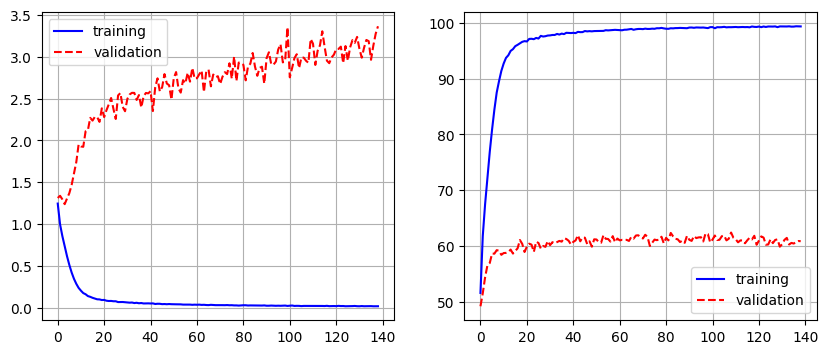

In [7]:
train_loss = history["train_loss"]
train_acc = history["train_acc"]
valid_loss = history["valid_loss"]
valid_acc = history["valid_acc"]
epoch = len(history["train_loss"])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_loss, 'b', label="training")
ax[0].plot(valid_loss, '--r', label="validation")
ax[0].legend()
ax[0].grid()

ax[1].plot(train_acc, 'b', label="training")
ax[1].plot(valid_acc, '--r', label="validation")
ax[1].legend()
ax[1].grid()
plt.show()

In [8]:
model.load_state_dict(torch.load(f"{save_model_path}high_acc.pth"))

<All keys matched successfully>

In [9]:
with torch.no_grad():
    pred, labels = model.predict(valid_x)

  0%|          | 0/52 [00:00<?, ?it/s]

In [10]:
accuracy_score(valid_y, labels.cpu())

0.6239277652370203

AUC per class: [0.8540246983139745, 0.8725201592436745, 0.8659064816524953, 0.8819815081970674, 0.8260698436322431, 0.961470793330844]


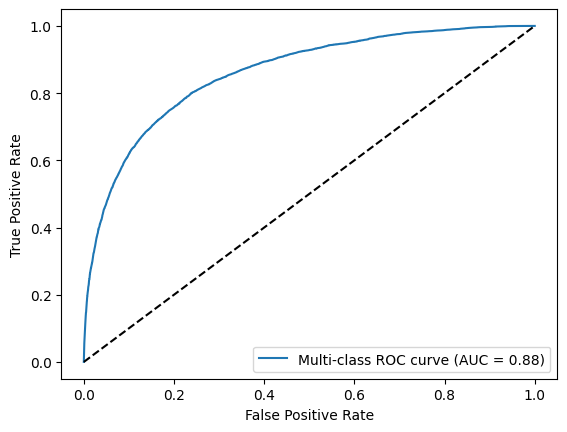

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

# 예측값과 레이블 값을 가져옵니다.
y_pred = pred.cpu()
y_true = valid_y

# Softmax 함수를 사용하여 확률값을 계산합니다.
y_pred = torch.softmax(y_pred, dim=1)

# 각 클래스에 대한 AUC 값을 계산합니다.
auc_list = []
for i in range(6):
    auc = roc_auc_score((y_true == i), y_pred[:, i].numpy())
    auc_list.append(auc)

# AUC 값을 출력합니다.
print("AUC per class:", auc_list)

# 각 클래스별 FPR과 TPR 값을 구합니다.
fpr_list = []
tpr_list = []
for i in range(6):
    fpr, tpr, _ = roc_curve((y_true == i), y_pred[:, i].numpy())
    fpr_list.append(fpr)
    tpr_list.append(tpr)

# 모든 클래스에 대한 FPR과 TPR 값을 평균 내어 멀티클래스 AUC 값을 구합니다.
mean_fpr = np.unique(np.concatenate(fpr_list))
mean_tpr = np.zeros_like(mean_fpr)
for i in range(5):
    mean_tpr += np.interp(mean_fpr, fpr_list[i], tpr_list[i])
mean_tpr /= 5

# 멀티클래스 AUC-ROC 커브를 그립니다.
plt.plot(mean_fpr, mean_tpr, label='Multi-class ROC curve (AUC = %0.2f)' % np.mean(auc_list))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_true=valid_y, y_pred=labels.cpu(), target_names=["A1", "A2", "A3", "A4", "A5", "A6"]))

              precision    recall  f1-score   support

          A1       0.59      0.56      0.57      1087
          A2       0.62      0.67      0.65      1331
          A3       0.55      0.69      0.61      1317
          A4       0.63      0.63      0.63      1092
          A5       0.63      0.40      0.49      1056
          A6       0.84      0.81      0.83       762

    accuracy                           0.62      6645
   macro avg       0.64      0.63      0.63      6645
weighted avg       0.63      0.62      0.62      6645

